# Read the data and prepare multiple time series

The method of choice is the analysis givven in [1] for time series' in a high dimensional space. In order to be able to process the data we have 



[1] C. Uhl, Analyse raumzeitlicher Daten strukturbildender Systeme, Verlag Shaker (1995)

Still to be found:
[]  K. Karhunen, "Zur Spektraltheorie stochastischer Prozesse," Ann. Acad. Sci. Fenn. A1, Math. Phys. 37 (1946)
 M. Loeve, “Fonctions aleatoires de second ordre,” Comptes Rendus De L'Académie Des Sciences, vol. 220, (1945).

### Load the respective libraries

In [1]:
from bs4 import BeautifulSoup
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import special
from scipy.special import sph_harm 

# nur fuer den Seiteneffekt: plt.gca(projection = '3d') funktioniert sonst nicht
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm

### Get the data

In [2]:
date='200922'
filenameC=date+'_series_covid19_confirmed_global.csv'
filenameD=date+'_series_covid19_deaths_global.csv'
filenameR=date+'_series_covid19_recovered_global.csv'
#htmlC = open("TableC.html").read()
htmlC = open(filenameC).read()
soupC = BeautifulSoup(htmlC)
TableC = soupC.find("table")
htmlD = open(filenameD).read()
soupD = BeautifulSoup(htmlD)
TableD = soupD.find("table")
htmlR = open(filenameR).read()
soupR = BeautifulSoup(htmlR)
TableR = soupR.find("table")


### Extract the header row from TableC/D/R, read data from the table and create a dictionary with all countries and the total of confirmed cases

In [3]:
# Some data of Johns Hopkins lacks the last entry being empty 
# and resulting in error of int(x)
def tryint(x):
    try:
        y=np.array([int(x[i]) for i in np.arange(len(x))])
    except ValueError:
        x[-1]=x[-2]
        y=np.array([int(x[i]) for i in np.arange(len(x))])
    return y
# TableC
# Header row
TableC_headrow= TableC.find('tr')
hcolumns = TableC_headrow.findAll('th')
output_row = []
output_rows = []
for column in hcolumns: output_row.append(column.text)
output_rows.append(output_row)
# Table
for TableC_row in TableC.findAll('tr'):
    columns = TableC_row.findAll('td')
    output_row = []
    for column in columns:
        output_row.append(column.text)
    if len(output_row) > 1: output_rows.append(output_row)
# Dictionary
yC={}
for i in np.arange(1,len(output_rows)):
    key=output_rows[i][2]
    x=output_rows[i][5:]
    if key in yC: 
        yC[key]=yC[key]+tryint(x)
    else:
        yC[key]=tryint(x)
# The following should be the same for all three
x=np.arange(len(yC.get('Germany')))
# TableD
# Header row
TableD_headrow= TableD.find('tr')
hcolumns = TableD_headrow.findAll('th')
output_row = []
output_rows = []
for column in hcolumns: output_row.append(column.text)
output_rows.append(output_row)
# Table
for TableD_row in TableD.findAll('tr'):
    columns = TableD_row.findAll('td')
    output_row = []
    for column in columns:
        output_row.append(column.text)
    if len(output_row) > 1: output_rows.append(output_row)
# Dictionary
yD={}
for i in np.arange(1,len(output_rows)):
    key=output_rows[i][2]
    x=output_rows[i][5:]
    if key in yD: 
        yD[key]=yD[key]+tryint(x)
    else:
        yD[key]=tryint(x)
# TableR
# Header row
TableR_headrow= TableR.find('tr')
hcolumns = TableR_headrow.findAll('th')
output_row = []
output_rows = []
for column in hcolumns: output_row.append(column.text)
output_rows.append(output_row)
# Table
for TableR_row in TableR.findAll('tr'):
    columns = TableR_row.findAll('td')
    output_row = []
    for column in columns:
        output_row.append(column.text)
    if len(output_row) > 1: output_rows.append(output_row)
# Dictionary
yR={}
for i in np.arange(1,len(output_rows)):
    key=output_rows[i][2]
    x=output_rows[i][5:]
    if key in yR: 
        yR[key]=yR[key]+tryint(x)
    else:
        yR[key]=tryint(x)
#
# Maybe some day we need this
# 
#
# Define the model function $e^{a\cdot (x-x_0)}$
def model(x,a,x0):
    return np.exp(a*(x-x0))
#
# Temporarily suppressed
# Caution the following is only for logarithmic representation
# ylog=y.copy()
# for key in y.keys():
#    ylog[key]=np.log10(ylog[key]+1)
#
# numerical ordering of countries NOT USED YES
# numbered=dict(zip(np.arange(len(y.keys())),y.keys()))
numbered=dict(zip(yC.keys(),np.arange(len(yC.keys()))))

### Save the data

In [4]:
np.save('Numbered.npy',numbered)
#
yConfirmed=np.array(list(yC.values()),dtype=float)
yDeaths=np.array(list(yD.values()),dtype=float)
yRecovered=np.array(list(yR.values()),dtype=float)
np.savez('CDR_Data.npz',yC=yConfirmed,yD=yDeaths,yR=yRecovered)

### Define plotting functions for the data retrieved, linear plot and log plot

In [5]:

def plotcountry(y,Country,istart,loglin):
    fig, ax = plt.subplots()
    for c in Country: 
        i=numbered[c]
        x=np.arange(len(y.get(c)[istart:]))
        if loglin==False: ax.plot(x[istart:],y.get(c)[istart:],label=c)
        if loglin==True: ax.plot(x[istart:],np.log10(1+y.get(c)[istart:]),label=c)
    legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
    #legend.get_frame().set_facecolor('C0')
    #plt.show()

### Plot choices of data

<IPython.core.display.Javascript object>


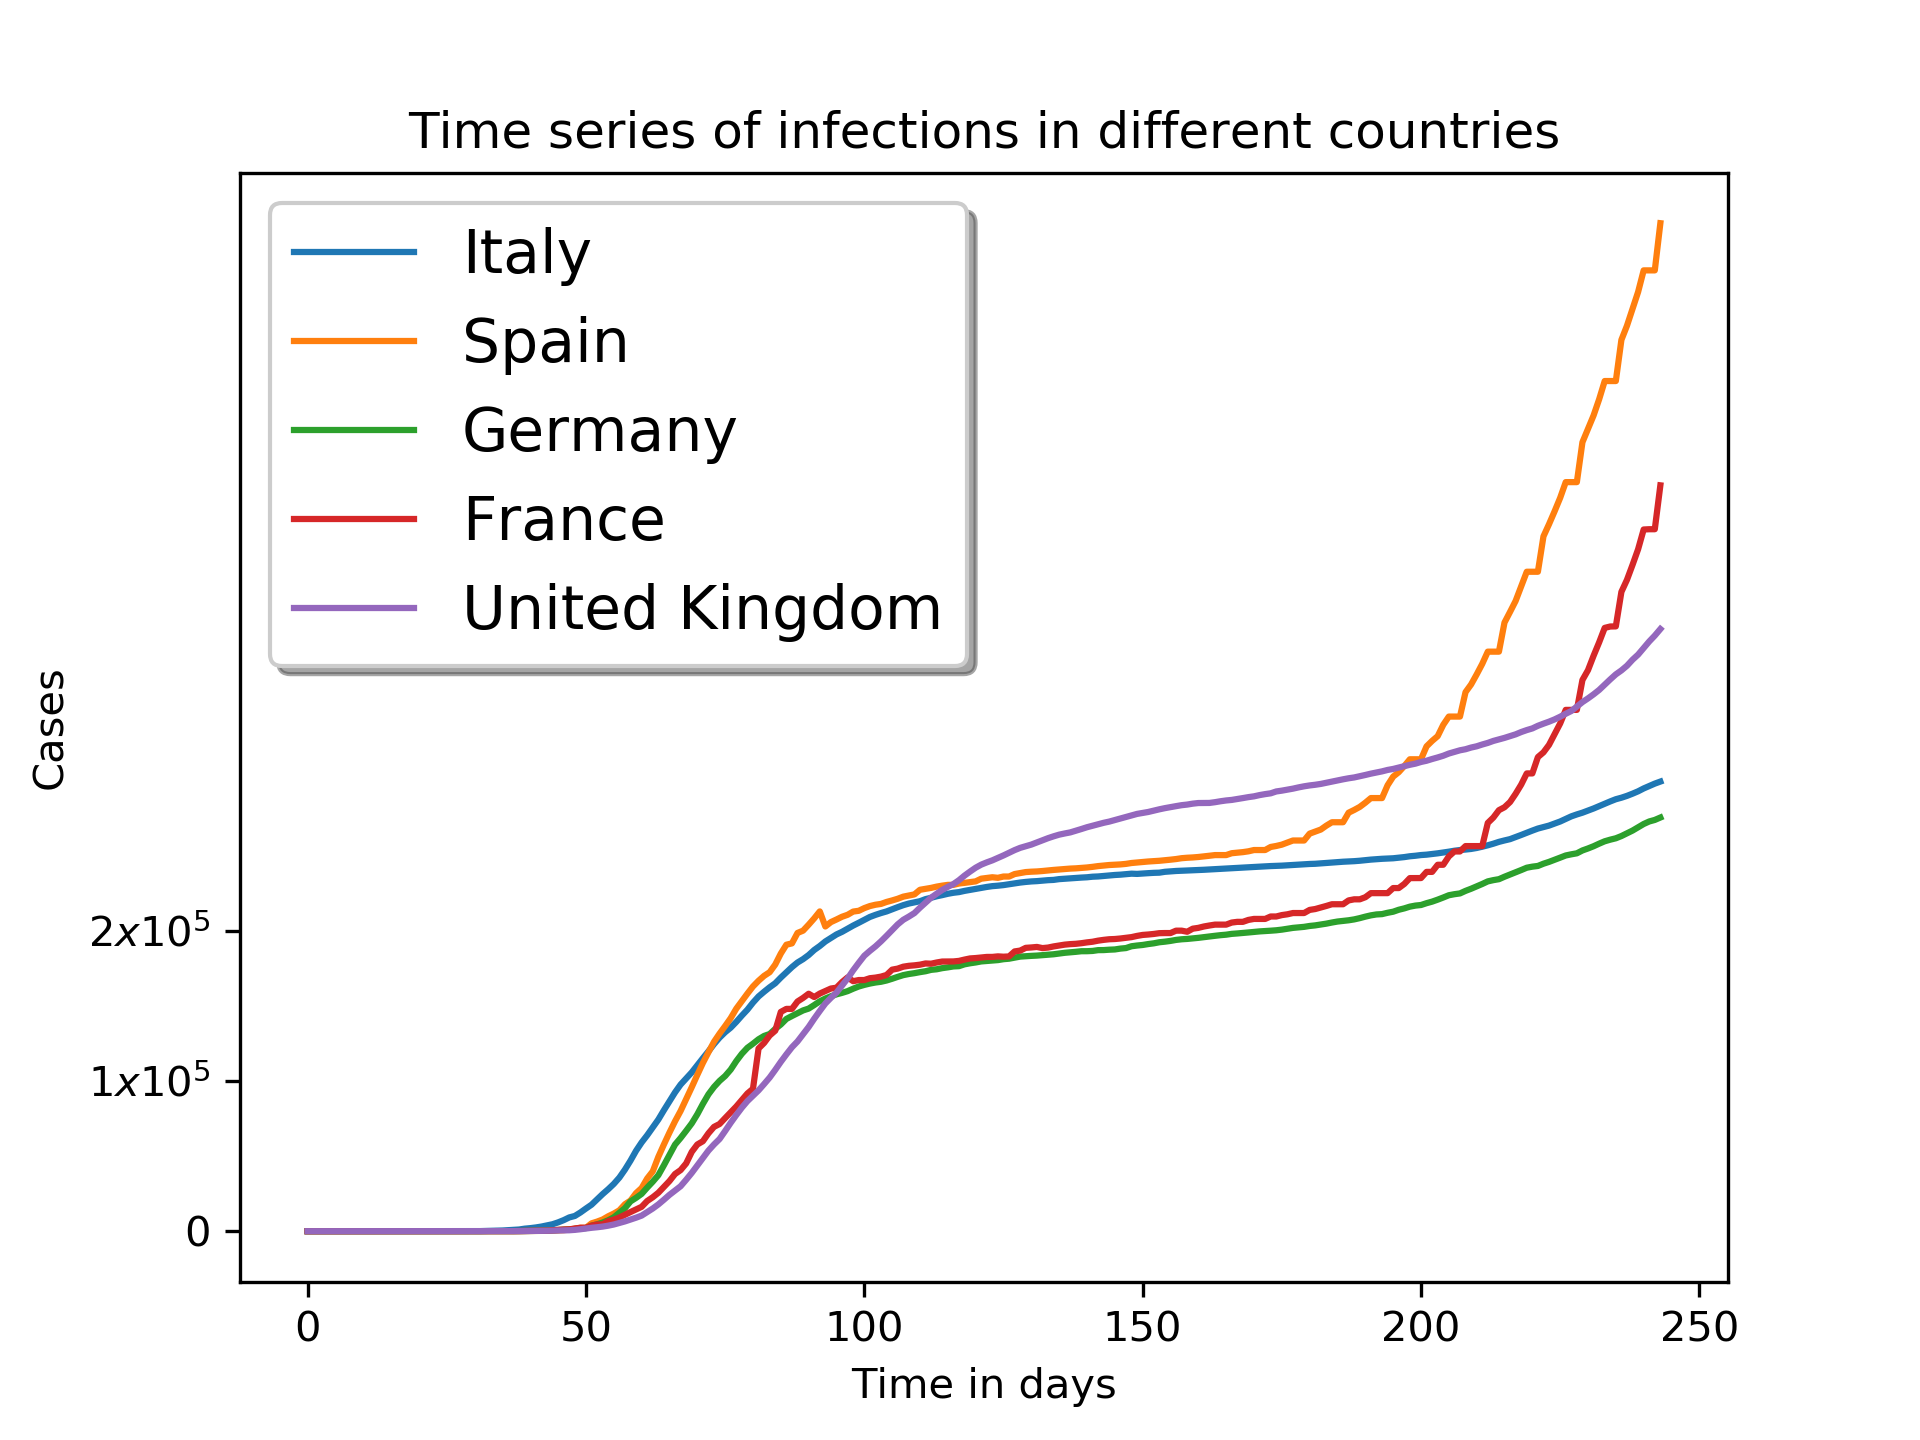

In [6]:
%matplotlib notebook
#
countries=['Italy','Spain','Germany','France','United Kingdom']
plotcountry(yC,countries,0,False)
plt.xlabel('Time in days')
plt.yticks([0,1e5,2e5],['0','$1x10^5$','$2x10^5$'])
plt.ylabel('Cases')
plt.title('Time series of infections in different countries')
plt.savefig('EUdiverse.png')

### Fit data to a simple exponential 

In [8]:
# Define the model function $e^{a\cdot (x-x_0)}$
def model(x,a,x0):
    return np.exp(a*(x-x0))
#
def f(x,a):
    return np.exp(-a*2*np.pi/(ny-1)*x)

<IPython.core.display.Javascript object>


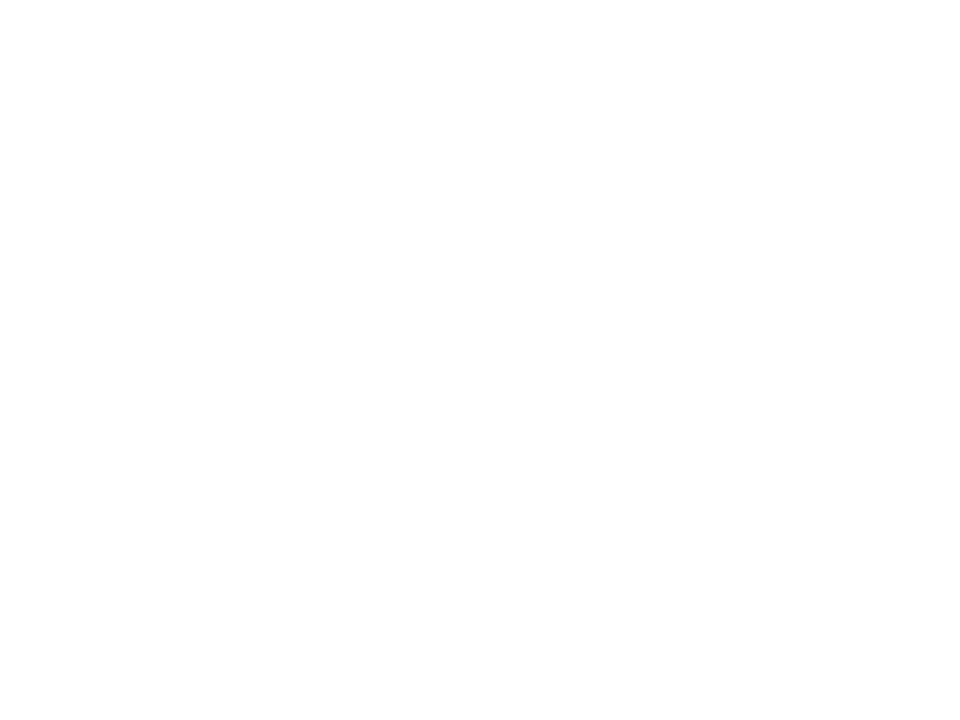

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 600.

In [9]:
%matplotlib notebook
# Fit to the model and plotit
countries=['US','Italy','Germany','France','Korea, South']
fig, ax = plt.subplots()
for c in countries:
    xdata=np.arange(len(yC.get(c)))
    ydata=yC.get(c)
    popt,pcov = curve_fit(model,xdata,ydata)
    #plt.plot()
    ax.plot(xdata,np.exp(popt[0]*(xdata-popt[1])),label=c+'-fit')
    ax.plot(xdata,ydata,label=c)
    #t=np.arange(len(yC.get('US')))
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-small')
plt.ylabel('Cases in mutliples of $10^6$')
plt.xlabel('Time in days')
plt.title('Titel')
plt.yticks([0,5e5,1e6,1.5e6,2e6],['$0$','$0.5$','$1.0$','$1.5$','$2.0$'])

In [ ]:
%matplotlib notebook
x=np.linspace(-2.,2.)
n=6
c=np.identity(n)
for i in np.arange(n):
    ymax=np.max(np.abs(np.polynomial.hermite.hermval(x,c[i])))
    plt.plot(x,np.polynomial.hermite.hermval(x,c[i])/ymax)

<IPython.core.display.Javascript object>


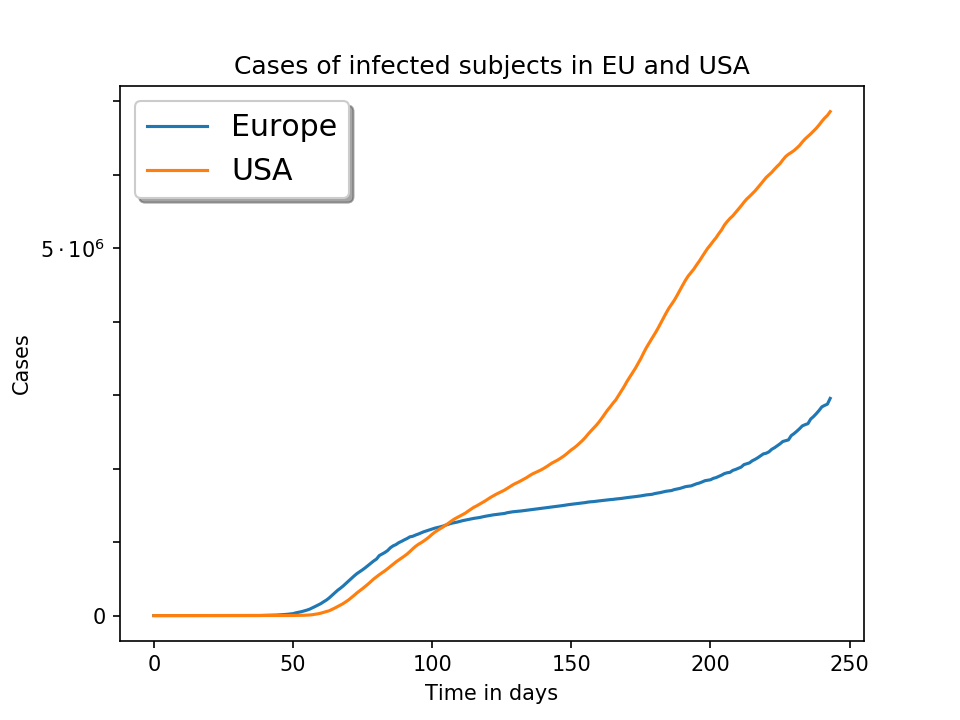

In [14]:
%matplotlib notebook
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
EUCountries=('Belgium','Bulgaria','Denmark','Germany','Estonia','Finland','France','Greece','Ireland','Italy','Croatia',
            'Latvia','Lithuania','Luxembourg','Malta','Netherlands','Austria','Poland','Portugal','Romania','Slovenia',
             'Sweden','Slovakia','Spain','Czechia','Hungary','Cyprus','United Kingdom')
yEU=np.zeros(len(yC.get('Germany')))
for c in EUCountries: 
    yEU+=yC.get(c)#/5.13e5
yUSA=yC.get('US')#/3.28e5
xdata=np.arange(len(yEU))
fig, ax = plt.subplots()
#popt,pcov = curve_fit(model,xdata,yEU)
ax.plot(xdata,yEU,label='Europe')
#ax.plot(xdata,np.exp(popt[0]*(xdata-popt[1])),label='EU-Fit')
#popt,pcov = curve_fit(model,xdata,yUSA)
ax.plot(yUSA,label='USA')
#ax.plot(xdata,np.exp(popt[0]*(xdata-popt[1])),label='USA-Fit')
plt.xlabel('Time in days')
plt.ylabel('Cases')
plt.yticks([0,1e6,2e6,3e6,4e6,5e6,6e6,7e6],['0','','','','','$5\cdot 10^6$','',''])
#plt.yticks([0,10,20,30,4,50,60])
#plt.ylabel('Cases per $1000$ population')
plt.title('Cases of infected subjects in EU and USA')
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
#plt.savefig('USAEUCases.png')
plt.savefig('USAEUCasesNormalized.png')

<IPython.core.display.Javascript object>


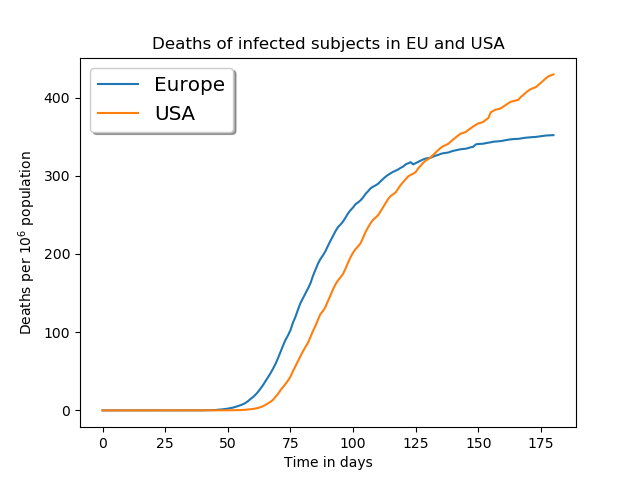

In [39]:
%matplotlib notebook
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
EUCountries=('Belgium','Bulgaria','Denmark','Germany','Estonia','Finland','France','Greece','Ireland','Italy','Croatia',
            'Latvia','Lithuania','Luxembourg','Malta','Netherlands','Austria','Poland','Portugal','Romania','Slovenia',
             'Sweden','Slovakia','Spain','Czechia','Hungary','Cyprus','United Kingdom')
yEU=np.zeros(len(yD.get('Germany')))
for c in EUCountries: 
    yEU+=yD.get(c)/5.13e2
yUSA=yD.get('US')/3.28e2
xdata=np.arange(len(yEU))
fig, ax = plt.subplots()
#popt,pcov = curve_fit(model,xdata,yEU)
ax.plot(xdata,yEU,label='Europe')
#ax.plot(xdata,np.exp(popt[0]*(xdata-popt[1])),label='EU-Fit')
#popt,pcov = curve_fit(model,xdata,yUSA)
ax.plot(yUSA,label='USA')
#ax.plot(xdata,np.exp(popt[0]*(xdata-popt[1])),label='USA-Fit')
plt.xlabel('Time in days')
plt.ylabel('Deaths per $10^6$ population')
#plt.ylabel('Deaths')
#plt.yticks([0,5e5,1e6],['0','$5\cdot 10^5$','$1\cdot 10^6$'])
#plt.yticks([0,1,2])
#plt.ylabel('Cases per 1000 population')
plt.title('Deaths of infected subjects in EU and USA')
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
#plt.savefig('USAEUCases.png')
plt.savefig('USAEUDeathsNormalized.png')

<IPython.core.display.Javascript object>


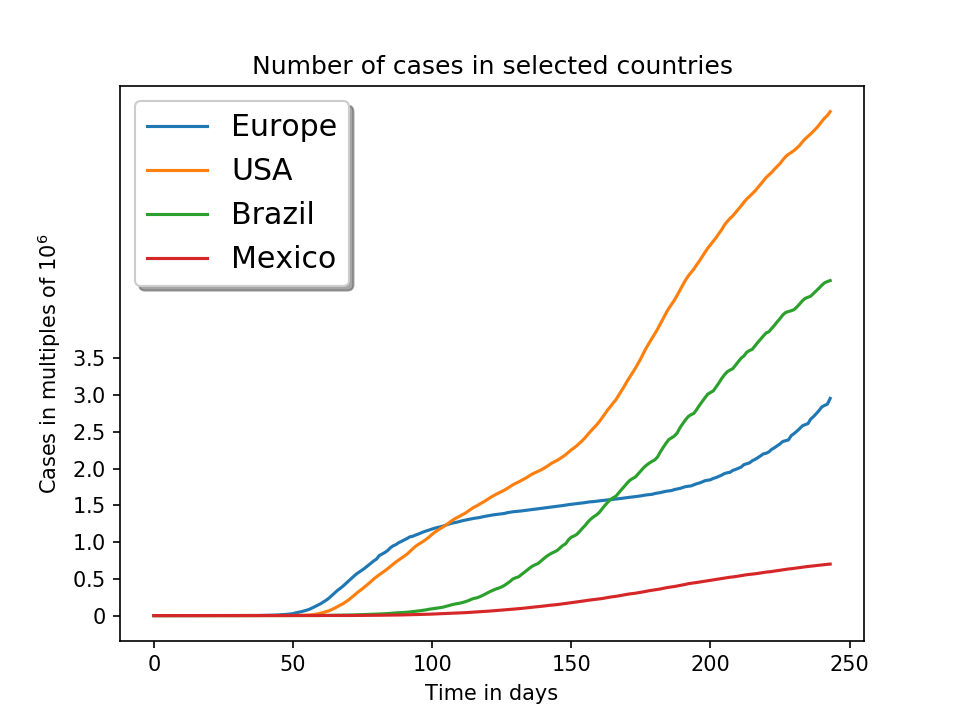

In [15]:
%matplotlib notebook
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
EUCountries=('Belgium','Bulgaria','Denmark','Germany','Estonia','Finland','France','Greece','Ireland','Italy','Croatia',
            'Latvia','Lithuania','Luxembourg','Malta','Netherlands','Austria','Poland','Portugal','Romania','Slovenia',
             'Sweden','Slovakia','Spain','Czechia','Hungary','Cyprus','United Kingdom')
yEU=np.zeros(len(yC.get('Germany')))
for c in EUCountries: 
    yEU+=yC.get(c)
yUSA=yC.get('US')
yKorea=yC.get('Mexico')
yBrazil=yC.get('Brazil')
xdata=np.arange(len(yEU))
fig, ax = plt.subplots()
#popt,pcov = curve_fit(model,xdata,yEU)
ax.plot(xdata,yEU,label='Europe')
#ax.plot(xdata,np.exp(popt[0]*(xdata-popt[1])),label='EU-Fit')
#popt,pcov = curve_fit(model,xdata,yUSA)
ax.plot(yUSA,label='USA')
ax.plot(yBrazil,label='Brazil')
ax.plot(yKorea,label='Mexico')
#ax.plot(xdata,np.exp(popt[0]*(xdata-popt[1])),label='USA-Fit')
plt.xlabel('Time in days')
plt.ylabel('Cases in multiples of $10^6$')
#plt.yticks([0,5e5,1e6],['0','$5\cdot 10^5$','$1\cdot 10^6$'])
#plt.yticks([0,1,2])
plt.yticks([0,5e5,1e6,1.5e6,2e6,2.5e6,3e6,3.5e6],["0","$0.5$","$1.0$","$1.5$","$2.0$","$2.5$","$3.0$","$3.5$"])
#plt.ylabel('Cases per 1000 population')
plt.title('Number of cases in selected countries')
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
#plt.savefig('USAEUCases.png')
plt.savefig('USAEUCasesNOTNormalized.png')

In [ ]:
%matplotlib notebook

x=np.linspace(0,1.)
n=6
for i in np.arange(1,n):
    zerosj=special.jn_zeros(i, 1)
    ymax=np.max(special.jv(i,zerosj*x))
    plt.plot(x,special.jv(i,zerosj*x)/ymax)
    #plt.plot(x,special.j1(x))

<IPython.core.display.Javascript object>


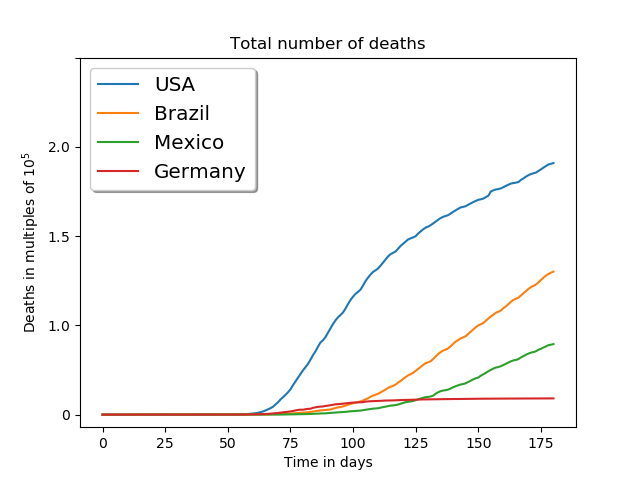

In [13]:
%matplotlib notebook
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
EUCountries=('Belgium','Bulgaria','Denmark','Germany','Estonia','Finland','France','Greece','Ireland','Italy','Croatia',
            'Latvia','Lithuania','Luxembourg','Malta','Netherlands','Austria','Poland','Portugal','Romania','Slovenia',
             'Sweden','Slovakia','Spain','Czechia','Hungary','Cyprus','United Kingdom')
yDEU=np.zeros(len(yD.get('Germany')))
yCEU=np.zeros(len(yC.get('Germany')))
for c in EUCountries: 
    yDEU+=yD.get(c)
    yCEU+=yC.get(c)
xdata=np.arange(len(yEU))
fig, ax = plt.subplots()
#popt,pcov = curve_fit(model,xdata,yEU)
#ax.plot(xdata,yDEU/(yCEU+1)*100,label='Europe')
#ax.plot(xdata,np.exp(popt[0]*(xdata-popt[1])),label='EU-Fit')
#popt,pcov = curve_fit(model,xdata,yUSA)
#ax.plot(yD.get('US')/(yC.get('US')+1)*100,label='USA')
#ax.plot(yD.get('Germany')/(yC.get('Germany')+1)*100,label='Germany')
#
#ax.plot(xdata,yDEU,label='Europe')
ax.plot(yD.get('US'),label='USA')
ax.plot(yD.get('Brazil'),label='Brazil')
ax.plot(yD.get('Mexico'),label='Mexico')
ax.plot(yD.get('Germany'),label='Germany')
#
#ax.plot(xdata,np.exp(popt[0]*(xdata-popt[1])),label='USA-Fit')
plt.xlabel('Time in days')
plt.ylabel('Deaths in multiples of $10^5$')# in %')
#plt.ylabel('Deaths')
plt.yticks([0,0.5e5,1.0e5,1.5e5,2.0e5],['0','$1.0$','$1.5$','$2.0$'])
#plt.yticks([0,1,2])
#plt.ylabel('Cases per 1000 population')
#plt.title('Percentage of deaths w.r.t. infected subjects')
plt.title('Total number of deaths')
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
#plt.savefig('USAEUCases.png')
plt.savefig('USAEUDeathsPercentage.png')

In [8]:
# All coordinates
Coordinates=np.zeros((len(output_rows),2))
for i in np.arange(len(output_rows)):
    Coordinates[i]=np.float(output_rows[i][3]),np.float(output_rows[i][4])
# All data
nC=len(yC)
nT=len(yC.get('US'))
yCsnapshot=np.zeros((nC,nT))
i=0
for ctry in yC:
    yCsnapshot[i]=yC.get(ctry)
    i+=1
# Here we define the real version of the SH
def SHreal_lm(l, m, phi_2d, theta_2d):
    if m<0:
        ylm = (np.sqrt(2)*(-1)**m)*sph_harm(-m, l, phi_2d, theta_2d)
        return ylm.imag
    elif m>0:
        #print("Just before casting to real... ")
        ylm = (np.sqrt(2)*(-1)**m)*sph_harm(-m, l, phi_2d, theta_2d)
        return ylm.real
    else:
        ylm = sph_harm(0, l, phi_2d, theta_2d)
        return ylm   

ValueError: could not convert string to float: 'Long'

In [1]:
lmax=3
n=0
for l in np.arange(lmax+1):n+=2*l+1
lm=np.zeros((n,2),dtype=int)
i=-1
for l in np.arange(lmax+1):
    for m in np.arange(-l,l+1):
        i+=1
        lm[i]=l,m
#


NameError: name 'np' is not defined

In [103]:
lm

array([[ 0.,  0.],
       [ 1., -1.],
       [ 1.,  0.],
       [ 1.,  1.],
       [ 2., -2.],
       [ 2., -1.],
       [ 2.,  0.],
       [ 2.,  1.],
       [ 2.,  2.],
       [ 3., -3.],
       [ 3., -2.],
       [ 3., -1.],
       [ 3.,  0.],
       [ 3.,  1.],
       [ 3.,  2.],
       [ 3.,  3.]])

In [67]:
l=2
np.arange(-l,l+1)

array([-2, -1,  0,  1,  2])

array([ 0, -1,  0,  1, -2, -1,  0,  1,  2, -3, -2, -1,  0,  1,  2,  3])

In [75]:
for i in np.arange(lmax+1):
    

3

In [76]:
np.arange(lmax+1)

array([0, 1, 2, 3])